# Imports

In [5]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares, UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL
except:
  Exception('Error Initialising Iminuit')

In [6]:
import os
from IPython.display import Latex
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from funcs import *
from stats import *

# funcs

# Calcolo

In [88]:
def analize(path, init=0):
    RES, SIG, MTH = get_data(path)
    N = init
    max_res, i_max_res = find_max(RES[1], N, prec=0.00001)
    max_sig, i_max_sig = find_max(SIG[1], N, prec=0.00001)
    zero_res, i_zero_res = find_zero(RES[1], N, prec=0.00001)
    zero_sig, i_zero_sig = find_zero(SIG[1], N, prec=0.00001)

    # plt.plot(RES[0], RES[1], label='Resistenza')
    # plt.plot(SIG[0], SIG[1], label='Segnale')
    

    # plt.plot(RES[0][i_max_res], max_res, 'ro')
    # plt.plot(SIG[0][i_max_sig], max_sig, 'ro')
    # plt.plot(RES[0][i_zero_res], zero_res, 'go')
    # plt.plot(SIG[0][i_zero_sig], zero_sig, 'go')

    # plt.legend()
    # print("Vout/Vin = ", max_res/max_sig)
    # print("fase = ", RES[0][i_zero_res]- SIG[0][i_zero_sig])
    
    return max_res/max_sig, np.abs(RES[0][i_zero_res]- SIG[0][i_zero_sig])


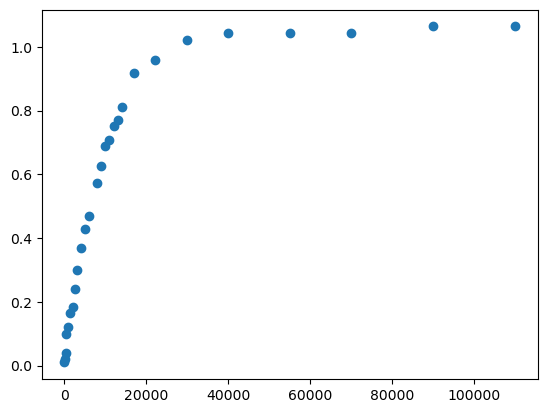

In [107]:
mods, fases, freqs = [], [], []

for i in os.listdir('data/RC'):
    path = 'data/RC/'+i+'/'
    mod, fase = analize(path, 300)
    mods.append(mod)
    fases.append(fase)
    freqs.append(float(i))
mods.pop()
fases.pop()
freqs.pop()
plt.scatter(freqs,mods)

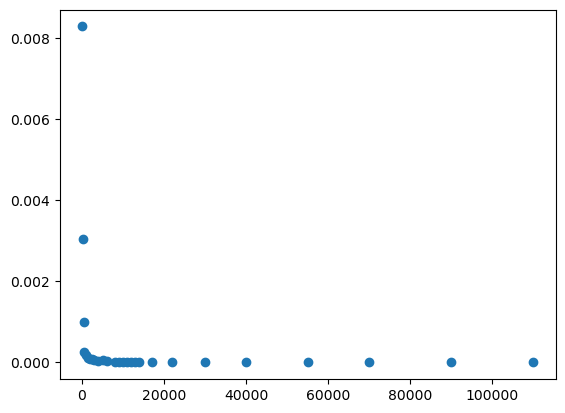

In [108]:
plt.scatter(freqs,fases)